# CS591S1 - Differential Privacy - Spring 2021

## Assignment 1

This notebook provides the solution to Exercise 4 of Assignment #1. This includes the algorithms for the two given scenarios in the instruction, the plots of the results, and finally, a short discussion of the results.

### The algorithms

Importing some essential libraries.

In [1]:
import numpy as np
from numpy import linalg as LA
import random
import matplotlib.pyplot as plt

Some useful functions to run the experiments.

In [2]:
# create a random secret vector of {0, 1}^n
def init(n):
    li = []
    for i in range (n):
        li.append(random.randint(0, 1))
    return np.array(li)

# the release mechanism
def release_mechanism(x):
    li = []
    s = 0
    for i in range (len(x)):
        s += x[i]
        r = random.randint(0, 1)
        s += r
        li.append(s)
        s -= r
    return np.array(li)

# sum of a given subset in an array
def sum_se(arr, start, end):
    s = 0
    for i in range (start, end + 1):
        s += arr[i]
    return s

Example of a secret vector and a noisy answer.

In [3]:
x = init(15)
print(x)

[0 0 1 1 0 0 1 0 0 0 1 0 0 1 1]


In [4]:
a = release_mechanism(x)
print(a)

[0 1 1 3 3 3 4 4 3 3 4 4 5 6 6]


The reconstruction algorithm for the first scenario.

In [5]:
def reconstruction_p1(a):
    li = []
    
    # handling first bit with case analysis
    if (a[0] == 0):
        li.append(0)
    elif (a[0] == 1):
        if a[1] == 2 or a[1] == 3:
            li.append(1)
        else:
            li.append(0)
    else: # a[0] == 2
        li.append(1)
        
    # handling the second to next-to-last bit
    for i in range (1, len(a) - 1):        
        diff1 = a[i] - a[i-1] # the difference in counts compared to one step in the past
        diff2 = a[i+1] - a[i] # the difference in counts compared to one step in the future
                
        # this means that the current bit is 1 and has noise
        if diff1 == 2:
            li.append(1)
        
        # uncertainty arises, look at one step ahead
        elif diff1 == 1:
            # making at least a more educated guess when unusual difference happens in the future
            if diff2 == -1:
                li.append(li[i-1])
            elif diff2 == 2:
                li.append(1)
            # double uncertainties, toss a coin
            else:
                li.append(random.randint(0, 1))
        
        # uncertainty arises, look at one step ahead
        elif diff1 == 0:
            # making at least a more educated guess when unusual difference happens in the future
            if diff2 == 2:
                li.append(li[i-1])
            elif diff2 == -1:
                li.append(1)
            # double uncertainties, toss a coin
            else:
                li.append(random.randint(0, 1))
        
        # this means that the current bit must be a zero
        elif diff1 == -1:
            li.append(0)

    # handling last bit
    last = len(a) - 1
    diff_last = a[last] - a[last - 1]
    if diff_last == 2:
        li.append(1)
    elif diff_last == -1:
        li.append(0)
    else:
        s = sum_se(li, 0, last - 1)
        if (s < a[last]):
            li.append(1)
        else:
            li.append(random.randint(0, 1))
    return np.array(li)

An example of running the reconstruction algorithm.

In [6]:
x = init(15)
print(x)

[1 1 0 1 1 1 0 1 1 1 0 0 0 0 1]


In [7]:
a = release_mechanism(x)
print(a)

[ 2  3  2  3  4  6  5  7  7  9  8  9  9  9 10]


In [8]:
x_prime = reconstruction_p1(a)
print(x_prime)

[1 1 0 1 1 1 0 1 1 1 0 0 1 1 0]


In [9]:
# the error (i.e. how many different bits between x and x')
x_diff = x_prime - x
print(LA.norm(x_diff, 1))

3.0


Running the experiment on the percentage of bits recovered on n = 100, 500, 1000, 5000, and 5000.

In [10]:
n = 100, 500, 1000, 5000, 50000
stds_s1 = []
means_s1 = []
for trial in n:
    print("Experiment of n = " + str(trial))
    std = 0
    mean = 0
    bits = [] # % of bits recovered
    for i in range (20):
        x = init(trial)
        a = release_mechanism(x)
        x_prime = reconstruction_p1(a)
        x_diff = x_prime - x
        bits.append((trial - LA.norm(x_diff, 1))*100/trial)
    mean = np.mean(bits)
    std = np.std(bits)
    stds_s1.append(std)
    means_s1.append(mean)
    print("Mean = " + str(mean))
    print("Standard deviation = " + str(std))
    print("---------------------------------")

Experiment of n = 100
Mean = 64.7
Standard deviation = 4.172529209005012
---------------------------------
Experiment of n = 500
Mean = 64.15
Standard deviation = 2.2749725273066486
---------------------------------
Experiment of n = 1000
Mean = 64.05499999999999
Standard deviation = 1.4302010348199308
---------------------------------
Experiment of n = 5000
Mean = 64.13
Standard deviation = 0.6994998213009047
---------------------------------
Experiment of n = 50000
Mean = 64.0744
Standard deviation = 0.2201586700541228
---------------------------------


Setting up for the second scenario.

In [11]:
# method for constructing vector w
def construct_w(x):
    li = []
    for i in range(len(x)):
        sample = [x[i], x[i], abs(1 - x[i])]
        li.append(random.choice(sample))
    return np.array(li)

In [12]:
x = init(10)
w = construct_w(x)
print(x)
print(w)

[0 0 1 1 0 0 1 0 1 1]
[0 0 1 0 1 0 1 1 1 1]


The reconstruction algorithm for the second scenario.

In [13]:
def reconstruction_p2(a, w):
    li = []
    
    # handling first bit with case analysis
    if (a[0] == 0):
        li.append(0)
    elif (a[0] == 1):
        if a[1] == 2 or a[1] == 3:
            li.append(1)
        else:
            li.append(0)
    else: # a[0] == 2
        li.append(1)
        
    # handling the second to next-to-last bit
    for i in range (1, len(a) - 1):        
        diff1 = a[i] - a[i-1] # the difference in counts compared to one step in the past
        diff2 = a[i+1] - a[i] # the difference in counts compared to one step in the future
                
        # this means that the current bit is 1 and has noise
        if diff1 == 2:
            li.append(1)
        
        # uncertainty arises, look at one step ahead
        elif diff1 == 1:
            # making at least a more educated guess when unusual difference happens in the future
            if diff2 == -1:
                li.append(li[i-1])
            elif diff2 == 2:
                li.append(1)
            # double uncertainties, access the vector w
            else:
                li.append(w[i])
        
        # uncertainty arises, look at one step ahead
        elif diff1 == 0:
            # making at least a more educated guess when unusual difference happens in the future
            if diff2 == 2:
                li.append(li[i-1])
            elif diff2 == -1:
                li.append(1)
            # double uncertainties, access the vector w
            else:
                li.append(w[i])
        
        # this means that the current bit must be a zero
        elif diff1 == -1:
            li.append(0)

    # handling last bit
    last = len(a) - 1
    diff_last = a[last] - a[last - 1]
    if diff_last == 2:
        li.append(1)
    elif diff_last == -1:
        li.append(0)
    else:
        s = sum_se(li, 0, last - 1)
        if (s < a[last]):
            li.append(1)
        else:
            li.append(w[i])
    return np.array(li)

Running the experiment on the percentage of bits recovered on n = 100, 500, 1000, 5000, and 5000.

In [14]:
n = 100, 500, 1000, 5000, 50000
# results of the second scenario
stds_s2 = []
means_s2 = []
for trial in n:
    print("Experiment of n = " + str(trial))
    std = 0
    mean = 0
    bits = [] # % of bits recovered
    for i in range (20):
        x = init(trial)
        w = construct_w(x)
        a = release_mechanism(x)
        x_prime = reconstruction_p2(a, w)
        x_diff = x_prime - x
        bits.append((trial - LA.norm(x_diff, 1))*100/trial)
    mean = np.mean(bits)
    std = np.std(bits)
    stds_s2.append(std)
    means_s2.append(mean)
    print("Mean = " + str(mean))
    print("Standard deviation = " + str(std))
    print("---------------------------------")

Experiment of n = 100
Mean = 74.0
Standard deviation = 4.604345773288535
---------------------------------
Experiment of n = 500
Mean = 72.51
Standard deviation = 1.78490896126385
---------------------------------
Experiment of n = 1000
Mean = 72.78999999999999
Standard deviation = 1.5927648916271364
---------------------------------
Experiment of n = 5000
Mean = 73.00800000000001
Standard deviation = 0.6278980809016709
---------------------------------
Experiment of n = 50000
Mean = 72.97389999999999
Standard deviation = 0.15380308839551798
---------------------------------


### Plotting the results.

A quick recap on the results of both scenarios:

In [15]:
print("The means in scenario 1 and 2 respectively.")
print(means_s1)
print(means_s2)

The means in scenario 1 and 2 respectively.
[64.7, 64.15, 64.05499999999999, 64.13, 64.0744]
[74.0, 72.51, 72.78999999999999, 73.00800000000001, 72.97389999999999]


In [16]:
print("The stds in scenario 1 and 2 respectively.")
print(stds_s1)
print(stds_s2)

The stds in scenario 1 and 2 respectively.
[4.172529209005012, 2.2749725273066486, 1.4302010348199308, 0.6994998213009047, 0.2201586700541228]
[4.604345773288535, 1.78490896126385, 1.5927648916271364, 0.6278980809016709, 0.15380308839551798]


Plotting.

In [17]:
# the method for plotting the data
def plot_data(s1, s2, n, title1, title2):
    plt.figure(figsize=(14, 4))
    
    plt.subplot(121)
    plt.plot(n, s1, 'r.', markersize=10, alpha=0.5)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("y", rotation=0, fontsize=15)
    plt.title(title1)

    plt.subplot(122)    
    plt.plot(n, s2, 'b.', markersize=10, alpha=0.5)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("y", rotation=0, fontsize=15)
    plt.title(title2)

In [18]:
n = [1, 2, 3, 4, 5] # stands for the order of the experiments, i.e. 100, 500, 1000, 5000, 50000 respectively.

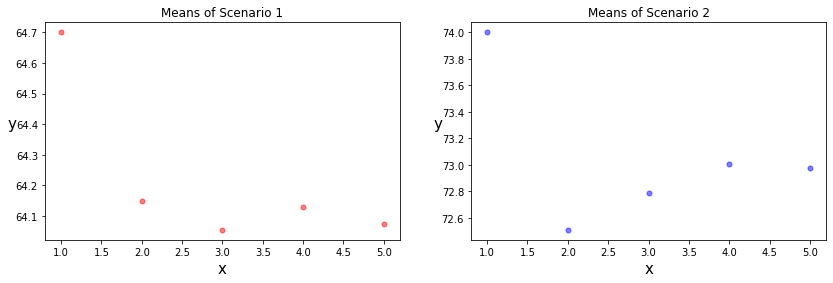

In [19]:
plot_data(means_s1, means_s2, n, "Means of Scenario 1", "Means of Scenario 2")

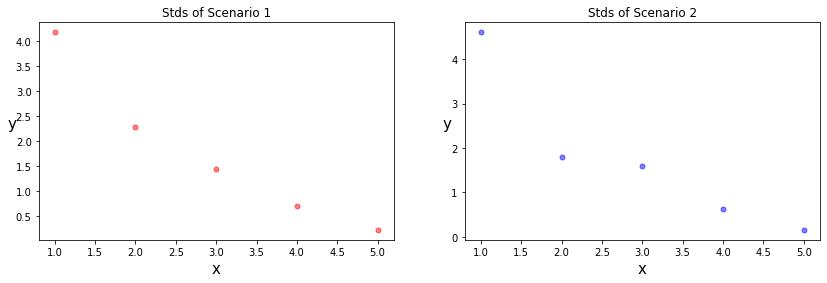

In [20]:
plot_data(stds_s1, stds_s2, n, "Stds of Scenario 1", "Stds of Scenario 2")

### Discussing the results

The results were worse than the given threshold which is not a surprise because the implemented methods were somewhat naive, namely, making coin tosses (or accessing the w-vector for the second scenario) when a couple of untertainties arise. Obviously, if some occurences of coin tosses were replaced with a more complex procedure giving more educated guesses, the results will become significantly better. This can be seen on the second scenario where all of the coin tosses were replaced with the access to w-vector which provides much better guesses, even with the naive approach.

The means in 5 experiments for both cases did not differ by much from each other, around 64 for the first case and 73 for the second case. The first mean (in both cases) seems to be a bit higher compared to the rest and one possible reason is that the data size was too small. The same happens to the first std and it is obvious that the standard deviation decreases as we experiment on a larger data set which provides tighter confidence intervals as n increases. Namely, when n gets to 50000, there's a 99% chance that we can recover ~73% the number of bits for the second scenario (or 64% for the first one).